In [24]:
pip install pymorphy2 nltk


Note: you may need to restart the kernel to use updated packages.


In [25]:
def read_tskv(file_path, limit=2000):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        count = 0
        for line in file:
            line_data = {}
            pairs = line.strip().split('\t')
            for pair in pairs:
                if '=' in pair:
                    key, value = pair.split('=', 1)
                    line_data[key] = value
            if line_data:
                data.append(line_data)
                count += 1
                if count >= limit:
                    break
    
    return [entry['text'] for entry in data]

file_path = './geo-reviews-dataset-2023.tskv'
texts = read_tskv(file_path)

In [26]:
import pymorphy2
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [27]:
# Инициализация морфологического анализатора и стеммера
morph = pymorphy2.MorphAnalyzer()
stemmer = SnowballStemmer("russian")

In [28]:
# загрузка стоп слов 
russian_stopwords = stopwords.words('russian')

In [29]:
import string
import re
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # заменяем все последовательности пробельных символов на один пробел
    text = text.replace('\\n', ' ')   # заменяем '\n' на пробел
    # Убираем цифры
    text = re.sub(r'\d+', '', text)
    # Приводим текст к нижнему регистру
    text = text.lower()
    # Убираем пунктуацию
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split() if word not in stopwords.words('russian')])
    return text


# Очистка текстов
cleaned_texts = [clean_text(text) for text in texts]

In [30]:
# Функция для лемматизации текста
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmatized_words)

# Функция для стемминга текста
def stem_text(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)


def tokenize_text(text):
    return ' '.join(text.split())

In [31]:
# пример отработки стеммнга / токенизации и лематизации на 1 тексте
lemmatized_text = lemmatize_text(cleaned_texts[3])
stemmed_text = stem_text(cleaned_texts[3])
tokenized_text = tokenize_text(cleaned_texts[3])
# Вывод результата
print("Исходный текст:", texts[3])
print("Очищенный текст:", cleaned_texts[3])
print("Лемматизированный текст:", lemmatized_text)
print("Стеммированный текст:", stemmed_text)
print("Токенизированный текст:", tokenized_text)

Исходный текст: Хорошие условия аренды. \nДружелюбный персонал.\nНо иногда бывают неутоюбные ботинки и крепления для сноуборда .\nНо у меня редкий размер ноги
Очищенный текст: хорошие условия аренды дружелюбный персонал бывают неутоюбные ботинки крепления сноуборда редкий размер ноги
Лемматизированный текст: хороший условие аренда дружелюбный персонал бывать неутоюбный ботинок крепление сноуборд редкий размер нога
Стеммированный текст: хорош услов аренд дружелюбн персона быва неутоюбн ботинк креплен сноуборд редк размер ног
Токенизированный текст: хорошие условия аренды дружелюбный персонал бывают неутоюбные ботинки крепления сноуборда редкий размер ноги


In [32]:
# Применение лемматизации  к очищенным текстам
lemmatized_texts = [lemmatize_text(text) for text in cleaned_texts]


stemmed_texts = [stem_text(text) for text in cleaned_texts]

In [33]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer


# Инициализация векторизатора с использованием собственного списка стоп-слов
tfidf = TfidfVectorizer(stop_words=russian_stopwords, max_features=5000)

# Преобразование текстов
X_lemmatized = tfidf.fit_transform(lemmatized_texts).toarray()
X_stemmed = tfidf.fit_transform(stemmed_texts).toarray()

print(X_lemmatized.shape)
print(X_stemmed.shape)

(2000, 5000)
(2000, 5000)


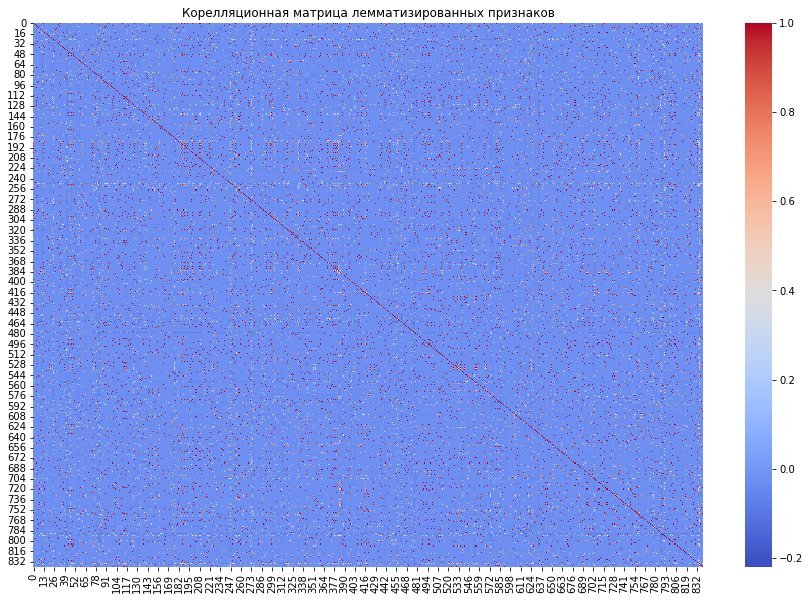

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Построение корелляционной матрицы для лемматизированных данных
plt.figure(figsize=(15, 10))  # Задаем размеры фигуры
correlation_matrix_lemmatized = pd.DataFrame(X_lemmatized).corr()
sns.heatmap(correlation_matrix_lemmatized, cmap='coolwarm')
plt.title('Корелляционная матрица лемматизированных признаков')
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC  # Пример альтернативной модели

# 1 - положительный отзыв, 0 - отрицательный отзыв
def read_ratings(file_path, limit=2000):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        count = 0
        for line in file:
            line_data = {}
            pairs = line.strip().split('\t')
            for pair in pairs:
                if '=' in pair:
                    key, value = pair.split('=', 1)
                    line_data[key] = value
            if line_data:
                data.append(line_data)
                count += 1
                if count >= limit:
                    break
    
    # Преобразование рейтингов в целые числа и замена значений
    ratings = []
    for entry in data:
        rating = round(float(entry['rating']))
        if rating >= 4:
            ratings.append(1)
        else:
            ratings.append(0)
    
    return ratings


 
# Извлечение бинарных меток из файла
y = read_ratings(file_path)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Разделение данных для лемматизированных текстов
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lemmatized, y, test_size=0.2, random_state=0)

# Разделение данных для стеммированных текстов
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stemmed, y, test_size=0.2, random_state=0)

# Определение моделей
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Gradient Boosting': GradientBoostingClassifier()
}

results_lemmatized = {}
results_stemmed = {}

# Обучение и оценка моделей для лемматизированных данных
for model_name, model in models.items():
    model.fit(X_train_lem, y_train_lem)
    accuracy_lem = model.score(X_test_lem, y_test_lem)
    results_lemmatized[model_name] = accuracy_lem

# Обучение и оценка моделей для стеммированных данных
for model_name, model in models.items():
    model.fit(X_train_stem, y_train_stem)
    accuracy_stem = model.score(X_test_stem, y_test_stem)
    results_stemmed[model_name] = accuracy_stem

accuracy_initial = results_stemmed['Gradient Boosting'] 
print('Results for Lemmatized Data:', results_lemmatized)
print('Results for Stemmed Data:', results_stemmed)

Results for Lemmatized Data: {'Logistic Regression': 0.905, 'Decision Tree': 0.865, 'Random Forest': 0.91, 'SVM': 0.905, 'Naive Bayes': 0.905, 'KNN': 0.875, 'Gradient Boosting': 0.92}
Results for Stemmed Data: {'Logistic Regression': 0.905, 'Decision Tree': 0.87, 'Random Forest': 0.91, 'SVM': 0.905, 'Naive Bayes': 0.905, 'KNN': 0.89, 'Gradient Boosting': 0.925}


In [42]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Выбор модели (Gradient Boosting)
model = GradientBoostingClassifier()

# Определение гиперпараметров для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Проведение Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_stem, y_train_stem)

# Лучшие параметры
best_params = grid_search.best_params_
print('Лучшие параметры:', best_params)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}


In [43]:
best_model = GradientBoostingClassifier(**best_params)
best_model.fit(X_train_stem, y_train_stem)

# Оценка модели
accuracy = best_model.score(X_test_stem, y_test_stem)
accuracy_optimized = accuracy
print('Точность улучшенной модели:', accuracy)


Точность улучшенной модели: 0.91


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Применение PCA до векторизации
pca_lem = PCA(n_components=0.95)
pca_stem = PCA(n_components=0.95)

X_reduced_lem = pca_lem.fit_transform(X_lemmatized)
X_reduced_stem = pca_stem.fit_transform(X_stemmed)

# Обратное преобразование PCA в текстовые данные
X_inverse_lem = pca_lem.inverse_transform(X_reduced_lem)
X_inverse_stem = pca_stem.inverse_transform(X_reduced_stem)

# Преобразование массивов numpy в строки
X_text_lem = [' '.join(row) for row in X_inverse_lem.astype(str)]
X_text_stem = [' '.join(row) for row in X_inverse_stem.astype(str)]

# Векторизация
tfidf = TfidfVectorizer(stop_words=russian_stopwords, max_features=5000)
X_final_lem = tfidf.fit_transform(X_text_lem).toarray()
X_final_stem = tfidf.fit_transform(X_text_stem).toarray()

# Разделение данных и обучение модели
X_train_final_lem, X_test_final_lem, y_train, y_test = train_test_split(X_final_lem, y, test_size=0.2, random_state=0)
X_train_final_stem, X_test_final_stem, y_train, y_test = train_test_split(X_final_stem, y, test_size=0.2, random_state=0)

best_model = GradientBoostingClassifier(**best_params)
best_model.fit(X_train_final_stem, y_train)
accuracy = best_model.score(X_test_final_stem, y_test)
accuracy_pca = accuracy
print('Accuracy with changed preprocessing order (Stemmed Data):', accuracy)


Accuracy with changed preprocessing order (Lemmatized Data): 0.855


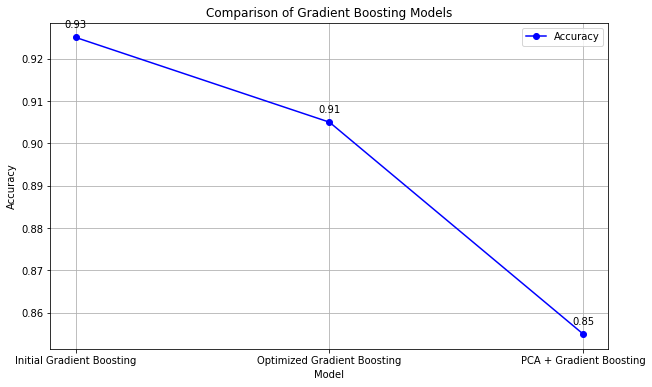

In [39]:
import matplotlib.pyplot as plt

accuracy_initial = results_stemmed['Gradient Boosting'] 

# Создадим словарь с результатами
results = {
    'Initial Gradient Boosting': accuracy_initial,
    'Optimized Gradient Boosting': accuracy_optimized,
    'PCA + Gradient Boosting': accuracy_pca
}

# Построим график
labels = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
plt.plot(labels, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')

# Добавление подписей на точки
for i, txt in enumerate(accuracies):
    plt.annotate(f'{txt:.2f}', (labels[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Gradient Boosting Models')
plt.legend()
plt.grid(True)
plt.show()


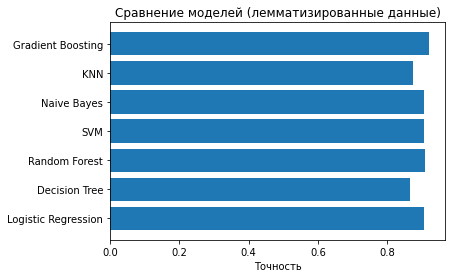

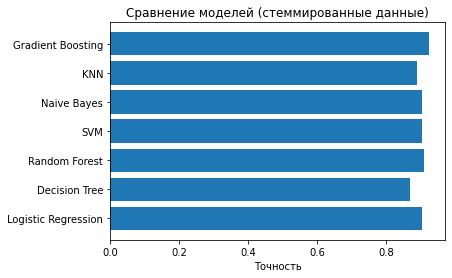

In [40]:
import matplotlib.pyplot as plt

# График точности моделей для лемматизированных данных
model_names = list(results_lemmatized.keys())
accuracies_lem = list(results_lemmatized.values())

plt.barh(model_names, accuracies_lem)
plt.xlabel('Точность')
plt.title('Сравнение моделей (лемматизированные данные)')
plt.show()

# График точности моделей для стеммированных данных
accuracies_stem = list(results_stemmed.values())

plt.barh(model_names, accuracies_stem)
plt.xlabel('Точность')
plt.title('Сравнение моделей (стеммированные данные)')
plt.show()
